# Table of Contents
 <p><div class="lev1"><a href="#Dynamic-Functional-Synchronizability-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dynamic Functional Synchronizability</a></div><div class="lev2"><a href="#Initialize-Environment-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2"><a href="#Generate-List-of-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate List of Data</a></div><div class="lev2"><a href="#Statistical-Analysis-of-Synchronizability-(With-Epoch)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Statistical Analysis of Synchronizability (With Epoch)</a></div><div class="lev3"><a href="#Frequency-Dependence-on-Synchronizability-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Frequency-Dependence on Synchronizability</a></div>

# Dynamic Functional Synchronizability

## Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import h5py

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

os.chdir('../')
import Codebase
os.chdir('./Analysis Notebooks/')

path_CoreData = '/Users/akhambhati/Remotes/hoth_research/CoreData/IEEG_Neocortical'
path_PeriphData = '/Users/akhambhati/Remotes/hoth_research/PeriphData/ds-VCR_PushPull'
path_InpData = path_PeriphData + '/e01-Dyne_FuncNetw'
path_ExpData = path_PeriphData + '/e02-Synchronizability'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/Users/akhambhati/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/akhambhati/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Generate List of Data

In [2]:
# Get clinical_metadata
df_meta = h5py.File('{}/clinical_metadata.mat'.format(path_CoreData), 'r')
meta_subj = [''.join(unichr(c) for c in df_meta[r])
             for r in df_meta['subject']['ID'][:, 0]]

# Get subject list
subj_event = [full_subj_path
              for full_subj_path in glob.iglob('{}/*.dyne_output.hdf'.format(path_InpData))]

subj_dict = {}
for path in subj_event:
    subj_id = path.split('/')[-1].split('.')[0].split('-')[0]
    epoch_id = path.split('/')[-1].split('.')[0].split('-')[1]
    event_id = subj_id + '-block-' + path.split('/')[-1].split('.')[0].split('-block-')[-1]
    epev_id = path.split('/')[-1].split('.')[0]
    band_id = path.split('/')[-1].split('.')[1]
    
    try:
        subj_dict[subj_id]
    except KeyError:
        subj_dict[subj_id] = {}

    try:
        subj_dict[subj_id][event_id]
    except KeyError:
        subj_dict[subj_id][event_id] = {}

    try:
        subj_dict[subj_id][event_id]['band_type']
    except KeyError:
        subj_dict[subj_id][event_id]['band_type'] = {}
        
    try:
        subj_dict[subj_id][event_id]['band_type'][band_id]
    except KeyError:
        subj_dict[subj_id][event_id]['band_type'][band_id] = {}
    
    subj_dict[subj_id][event_id]['band_type'][band_id][epoch_id] = \
               {'dyne_output': path,
                'dyne_log': '{}/{}.{}.dyne_log.csv'.format(path_InpData,
                                                           epev_id,
                                                           band_id)
               }
    
    # Get the seizure type for the subject/event
    meta_ix = np.flatnonzero(np.array(meta_subj) == subj_id)
    meta_ref = df_meta['subject']['SeizureType'][meta_ix, 0]
    sz_types = [''.join(unichr(c) for c in df_meta[r])
                for r in df_meta[meta_ref][0, :]]
    sz_type = sz_types[int(event_id.split('-')[-1])-1]
    
    if (sz_type == 'SPS') or (sz_type == 'CPS'):
        subj_dict[subj_id][event_id]['seizure_type'] = 'PS'
    if sz_type == 'CPS+GTC':
        subj_dict[subj_id][event_id]['seizure_type'] = 'PS+GEN'
        
    # Get the SOZ/NSOZ Channels
    df_signal = h5py.File('{}/{}/{}.mat'.format(path_CoreData, subj_id, epev_id), 'r')
    meta_ref = df_meta['subject']['Channels'][meta_ix, 0]
    chan_lbl = [''.join(unichr(c) for c in df_meta[rr])
                for rr in df_meta[meta_ref][0, :]]
    soz_lbl = [''.join(unichr(c) for c in df_signal[r])
               for r in df_signal['channels_soz'][0, :]]
    soz_ix = np.array(
            [chan_ix for chan_ix in xrange(len(chan_lbl))
                if chan_lbl[chan_ix] in soz_lbl])
    nsoz_ix = np.setdiff1d(np.arange(len(chan_lbl)), soz_ix)
    
    chan_loc = []
    for ix in xrange(len(chan_lbl)):
        if ix in soz_ix:
            chan_loc.append('SOZ')
        if ix in nsoz_ix:
            chan_loc.append('NSOZ')
    chan_loc = np.array(chan_loc)
    assert len(chan_loc) == len(chan_lbl)
    subj_dict[subj_id][event_id]['channel_loc'] = chan_loc
    subj_dict[subj_id][event_id]['channel_lbl'] = chan_lbl
    df_signal.close()

df_meta.close()  

## Statistical Analysis of Synchronizability (With Epoch)

In [4]:
df = pd.DataFrame([], columns=['Subject_ID',
                               'Event_ID',
                               'Seizure_ID',
                               'Band_ID',
                               'Epoch_ID',
                               'Div_ID',
                               'MeanSync'])
n_win_div = 5

tot_cnt = 0
for subj_id in subj_dict.iterkeys():
    for event_id in subj_dict[subj_id].iterkeys():
        for band_id in subj_dict[subj_id][event_id].iterkeys():
            
            if band_id == 'seizure_type':
                sz_type = subj_dict[subj_id][event_id][band_id]
                continue

            for epoch_id in subj_dict[subj_id][event_id][band_id].iterkeys():
                f_dict = subj_dict[subj_id][event_id][band_id][epoch_id]
                
                # Get data from DyNe
                dyne_out = f_dict['dyne_output']
                dyne_log = f_dict['dyne_log']

                df_log = pd.read_csv(dyne_log, delimiter=',')
                pipe_hash = np.array(df_log[df_log.PIPE_NAME == 'Synchronizability'].DOWNSTREAM_HASH)[0]

                df_outp = h5py.File(dyne_out, 'r')
                ev_sync = df_outp[pipe_hash]['data'][:, 0, 0]
                
                # Divide event into bins
                resol = ev_sync.shape[0] / float(n_win_div)
                if resol < 1.0:
                    print('Event: {}-{}-{}, is too short.'.format(subj_id,
                                                                  epoch_id,
                                                                  event_id))
                for div_id in xrange(n_win_div):
                    div_ev_sync = ev_sync[int(div_id*resol):int((div_id+1)*resol)]
                    avg_sync = np.mean(div_ev_sync)
                    
                    df_add = pd.DataFrame({'Subject_ID': [subj_id],
                                           'Event_ID': [event_id],
                                           'Seizure_ID': [sz_type],
                                           'Band_ID': [band_id],
                                           'Epoch_ID': [epoch_id],
                                           'Div_ID': [div_id],
                                           'MeanSync': [avg_sync]},
                                          index=[tot_cnt])
                    df = pd.concat([df, df_add])
                    tot_cnt += 1
                df_outp.close()
df.to_csv('{}/Population_epoch.csv'.format(path_ExpData))

### Frequency-Dependence on Synchronizability

"\nfor band_sel in np.unique(df.Band_ID):\n    for epoch_sel in epoch_order:\n        curve_list = [] \n        type_psgen_ix = []\n        type_ps_ix = []        \n        for ev_ix, event_sel in enumerate(np.unique(df.Event_ID)):\n            df_sel = df.loc[\n                df.Band_ID == band_sel].loc[\n                df.Event_ID == event_sel].loc[\n                df.Epoch_ID == epoch_sel]\n            curve_list.append(df_sel.sort_values(by='Div_ID').MeanSync)\n            \n            if (df_sel.Seizure_ID == 'PS+GEN').all():\n                type_psgen_ix.append(ev_ix)\n            elif (df_sel.Seizure_ID == 'PS').all():\n                type_ps_ix.append(ev_ix)\n        \n        curve_list = np.array(curve_list).T\n        pval = Codebase.Statistics.fda.curve_test(curve_list,\n                                                  type_psgen_ix, type_ps_ix,\n                                                  n_perm=1000000)\n        print('Frequency: %s, Epoch: %s, p-value: %0.3e

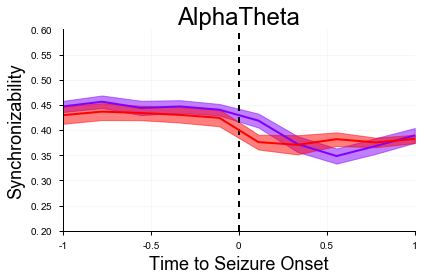

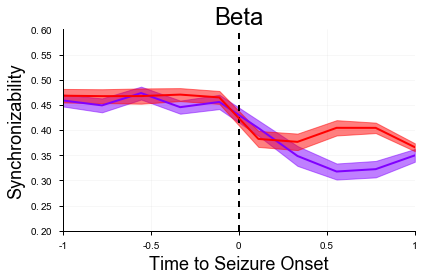

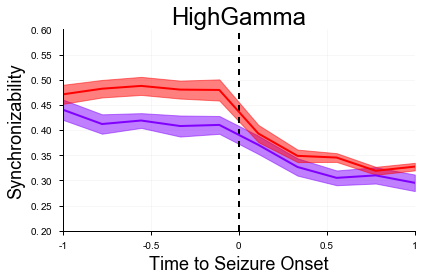

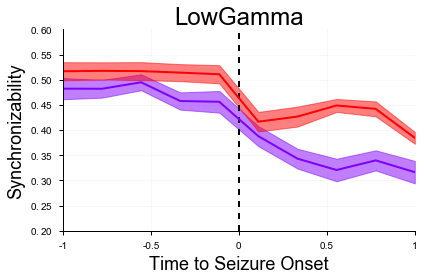

In [21]:
%matplotlib inline

df = pd.read_csv('{}/Population_epoch.csv'.format(path_ExpData))

# Set plotting parameters
cmap = plt.cm.get_cmap('rainbow', len(np.unique(df.Seizure_ID)))
clr = cmap(np.arange(len(np.unique(df.Seizure_ID))))
epoch_order = ['preictal', 'ictal']

# Plot
for band_sel in np.unique(df.Band_ID):
    plt.figure()
    ax = plt.subplot(111)

    for sz_sel_i, sz_sel in enumerate(np.unique(df.Seizure_ID)):
        ev_div_mean = []
        ev_div_upper = []
        ev_div_lower = []
    
        for epoch_sel in epoch_order:
            ep_mean = []
            for div_sel in np.unique(df.Div_ID):
                df_sel = df.loc[
                    df.Band_ID == band_sel].loc[
                    df.Seizure_ID == sz_sel].loc[
                    df.Epoch_ID == epoch_sel].loc[
                    df.Div_ID == div_sel]

                mean_sync = np.mean(df_sel.MeanSync)
                upper_sync = mean_sync + np.std(df_sel.MeanSync) / np.sqrt(len(df_sel)) 
                lower_sync = mean_sync - np.std(df_sel.MeanSync) / np.sqrt(len(df_sel))

                ev_div_mean.append(mean_sync)
                ev_div_upper.append(upper_sync)
                ev_div_lower.append(lower_sync)

        ax.plot(range(len(ev_div_mean)), ev_div_mean, color=clr[sz_sel_i])
        ax.fill_between(range(len(ev_div_mean)), ev_div_upper, ev_div_lower,
                        color=clr[sz_sel_i], alpha=0.5)
        ax.set_title(band_sel)
        
        ticks = ax.get_xticks()       
        ax.set_xticks(np.linspace(ticks[0], ticks[-1], 5))
        ax.set_xticklabels([-1, -0.5, 0, 0.5, 1])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Time to Seizure Onset')
        
        ax.set_ylim([0.2, 0.6])
        ax.set_ylabel('Synchronizability')
        
        ax.vlines(0.5*(ticks[-1]-ticks[0]), 0.2, 0.6,
                  color='black', linestyles='dashed')
        
    plt.savefig('./e02-Figures/Synchronizability-sz_type-{}.svg'.format(band_sel))        

    
# Compute the FDA
"""
for band_sel in np.unique(df.Band_ID):
    for epoch_sel in epoch_order:
        curve_list = [] 
        type_psgen_ix = []
        type_ps_ix = []        
        for ev_ix, event_sel in enumerate(np.unique(df.Event_ID)):
            df_sel = df.loc[
                df.Band_ID == band_sel].loc[
                df.Event_ID == event_sel].loc[
                df.Epoch_ID == epoch_sel]
            curve_list.append(df_sel.sort_values(by='Div_ID').MeanSync)
            
            if (df_sel.Seizure_ID == 'PS+GEN').all():
                type_psgen_ix.append(ev_ix)
            elif (df_sel.Seizure_ID == 'PS').all():
                type_ps_ix.append(ev_ix)
        
        curve_list = np.array(curve_list).T
        pval = Codebase.Statistics.fda.curve_test(curve_list,
                                                  type_psgen_ix, type_ps_ix,
                                                  n_perm=1000000)
        print('Frequency: %s, Epoch: %s, p-value: %0.3e' % (band_sel, epoch_sel, pval))
"""

- Frequency: AlphaTheta, Epoch: preictal, p-value: 4.067e-01
- Frequency: AlphaTheta, Epoch: ictal, p-value: 8.871e-01
- Frequency: Beta, Epoch: preictal, p-value: 5.043e-01
- Frequency: Beta, Epoch: ictal, p-value: 1.179e-02
- Frequency: HighGamma, Epoch: preictal, p-value: 1.566e-02
- Frequency: HighGamma, Epoch: ictal, p-value: 5.012e-02
- Frequency: LowGamma, Epoch: preictal, p-value: 9.199e-02
- Frequency: LowGamma, Epoch: ictal, p-value: 2.670e-04